Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted files to: /content/infrared_dataset
✅ Total image files found: 140
  subject mask_status image_type             pose  \
0       1        mask   infrared          head-up   
1       1        mask   infrared   head-turn-left   
2       1        mask   infrared  head-turn-right   
3       1        mask   infrared  head-roll-right   
4       1        mask   infrared        head-down   

                                           file_path  
0  /content/infrared_dataset/1/mask/infrared/head...  
1  /content/infrared_dataset/1/mask/infrared/head...  
2  /content/infrared_dataset/1/mask/infrared/head...  
3  /content/infrared_dataset/1/mask/infrared/head...  
4  /content/infrared_dataset/1/mask/infrared/head...  
✅ Paired infrared + RGB samples: 70
✅ Manifest saved to: /content/infrared_manifest.csv


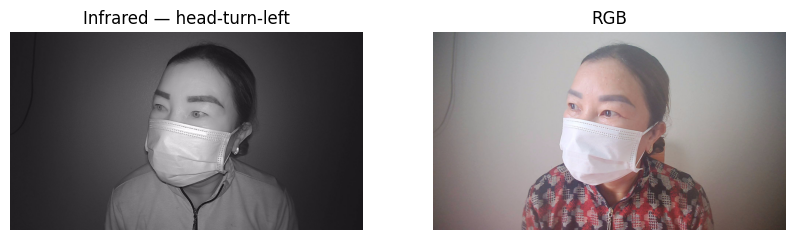

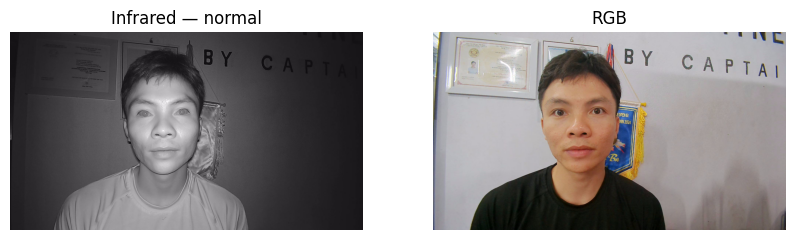

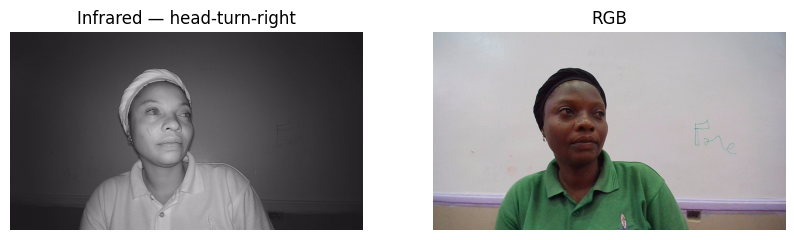

✅ Infrared-only manifest saved to: /content/infrared_only_manifest.csv

🎯 Dataset ready — next step: preprocessing & feature extraction.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile, re, pandas as pd, cv2, matplotlib.pyplot as plt
from tqdm import tqdm

ZIP_PATH = "/content/drive/MyDrive/archive.zip"  
EXTRACT_PATH = "/content/infrared_dataset"

os.makedirs(EXTRACT_PATH, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(EXTRACT_PATH)

print("✅ Extracted files to:", EXTRACT_PATH)

records = []
for root, dirs, files in os.walk(EXTRACT_PATH):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            rel = os.path.relpath(os.path.join(root, f), EXTRACT_PATH)
            parts = rel.split(os.sep)
            if len(parts) >= 4:
                subject = parts[0]
                mask_status = parts[1]         
                image_type = parts[2]          
                pose = os.path.splitext(parts[3])[0]
                pose_clean = re.sub(r'_(ir|rgb)$', '', pose, flags=re.IGNORECASE)
                records.append({
                    'subject': subject,
                    'mask_status': mask_status,
                    'image_type': image_type,
                    'pose': pose_clean,
                    'file_path': os.path.join(root, f)
                })

data = pd.DataFrame(records)
print(f"✅ Total image files found: {len(data)}")
print(data.head())

infra = data[data['image_type'] == 'infrared']
rgb   = data[data['image_type'] == 'photos']

paired = pd.merge(
    infra, rgb,
    on=['subject', 'mask_status', 'pose'],
    suffixes=('_ir', '_rgb'),
    how='inner'
)

print(f"✅ Paired infrared + RGB samples: {len(paired)}")

manifest_path = "/content/infrared_manifest.csv"
paired.to_csv(manifest_path, index=False)
print("✅ Manifest saved to:", manifest_path)

if len(paired) > 0:
    import random
    sample_rows = paired.sample(min(3, len(paired)))
    for _, row in sample_rows.iterrows():
        ir_img  = cv2.imread(row.file_path_ir)
        rgb_img = cv2.imread(row.file_path_rgb)
        if ir_img is None or rgb_img is None:
            continue
        ir_img  = cv2.cvtColor(ir_img,  cv2.COLOR_BGR2RGB)
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].imshow(ir_img);  ax[0].set_title(f"Infrared — {row.pose}")
        ax[1].imshow(rgb_img); ax[1].set_title("RGB")
        for a in ax: a.axis("off")
        plt.show()
else:
    print("⚠️ No paired RGB images found — proceeding with infrared-only dataset.")

infra_only_path = "/content/infrared_only_manifest.csv"
infra.to_csv(infra_only_path, index=False)
print("✅ Infrared-only manifest saved to:", infra_only_path)

print("\n🎯 Dataset ready — next step: preprocessing & feature extraction.")

✅ Loaded manifest with 70 samples


100%|██████████| 70/70 [00:42<00:00,  1.63it/s]


✅ Processed 70 infrared face crops saved in /content/processed_ir_faces
✅ Processed manifest saved to: /content/processed_ir_manifest.csv


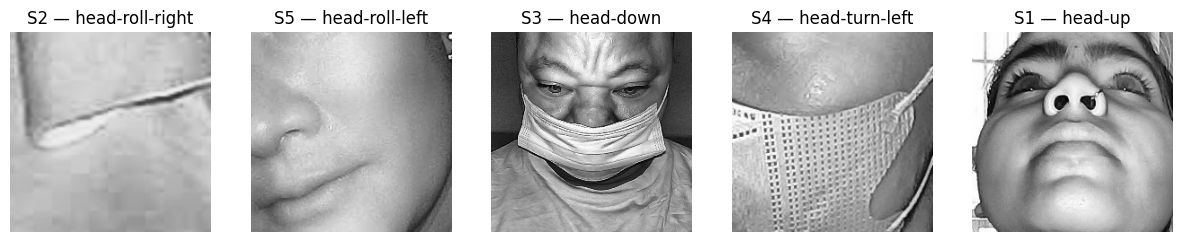


🎯 Preprocessing complete — faces cropped, contrast enhanced, resized to 224×224.
Next step → Feature Extraction / CNN Model Training.


In [5]:
import os, cv2, pandas as pd, numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow

manifest_path = "/content/infrared_manifest.csv"  # fallback to IR-only manifest if empty
if os.path.exists(manifest_path):
    data = pd.read_csv(manifest_path)
else:
    data = pd.read_csv("/content/infrared_only_manifest.csv")

print(f"✅ Loaded manifest with {len(data)} samples")

def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

OUTPUT_DIR = "/content/processed_ir_faces"
os.makedirs(OUTPUT_DIR, exist_ok=True)

processed_records = []

for idx, row in tqdm(data.iterrows(), total=len(data)):
    ir_path = row.get("file_path_ir", row.get("file_path", None))
    if ir_path is None or not os.path.exists(ir_path):
        continue

    img = cv2.imread(ir_path)
    if img is None:
        continue

    img_clahe = apply_clahe(img)

    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3, minSize=(50, 50))

    if len(faces) == 0:
        h, w = gray.shape
        size = min(h, w) // 2
        x = (w - size) // 2
        y = (h - size) // 2
        face_crop = img_clahe[y:y+size, x:x+size]
    else:
        x, y, w, h = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)[0]
        face_crop = img_clahe[y:y+h, x:x+w]

    face_crop_resized = cv2.resize(face_crop, (224, 224))
    save_path = os.path.join(OUTPUT_DIR, f"subject{row['subject']}_{row['mask_status']}_{row['pose']}.jpg")
    cv2.imwrite(save_path, face_crop_resized)

    processed_records.append({
        'subject': row['subject'],
        'mask_status': row['mask_status'],
        'pose': row['pose'],
        'processed_path': save_path
    })

print(f"✅ Processed {len(processed_records)} infrared face crops saved in {OUTPUT_DIR}")

processed_df = pd.DataFrame(processed_records)
processed_manifest_path = "/content/processed_ir_manifest.csv"
processed_df.to_csv(processed_manifest_path, index=False)
print("✅ Processed manifest saved to:", processed_manifest_path)

samples = processed_df.sample(min(5, len(processed_df)))
fig, axs = plt.subplots(1, len(samples), figsize=(15, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img = cv2.imread(row['processed_path'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(f"S{row['subject']} — {row['pose']}")
    axs[i].axis("off")
plt.show()

print("\n🎯 Preprocessing complete — faces cropped, contrast enhanced, resized to 224×224.")
print("Next step → Feature Extraction / CNN Model Training.")

✅ Loaded 70 preprocessed images
Training: 56 | Validation: 14


Epoch 1/10: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


Epoch 1: Train Loss=0.6901, Val Loss=0.6920, Val Acc=42.86%


Epoch 2/10: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Epoch 2: Train Loss=0.6903, Val Loss=0.6845, Val Acc=42.86%


Epoch 3/10: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Epoch 3: Train Loss=0.6643, Val Loss=0.6769, Val Acc=57.14%


Epoch 4/10: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Epoch 4: Train Loss=0.6657, Val Loss=0.6663, Val Acc=50.00%


Epoch 5/10: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Epoch 5: Train Loss=0.6154, Val Loss=0.6420, Val Acc=71.43%


Epoch 6/10: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


Epoch 6: Train Loss=0.6275, Val Loss=0.6395, Val Acc=50.00%


Epoch 7/10: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Epoch 7: Train Loss=0.5494, Val Loss=0.6123, Val Acc=50.00%


Epoch 8/10: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Epoch 8: Train Loss=0.5081, Val Loss=0.6165, Val Acc=50.00%


Epoch 9/10: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 9: Train Loss=0.5175, Val Loss=0.6595, Val Acc=50.00%


Epoch 10/10: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Epoch 10: Train Loss=0.4747, Val Loss=0.5398, Val Acc=64.29%


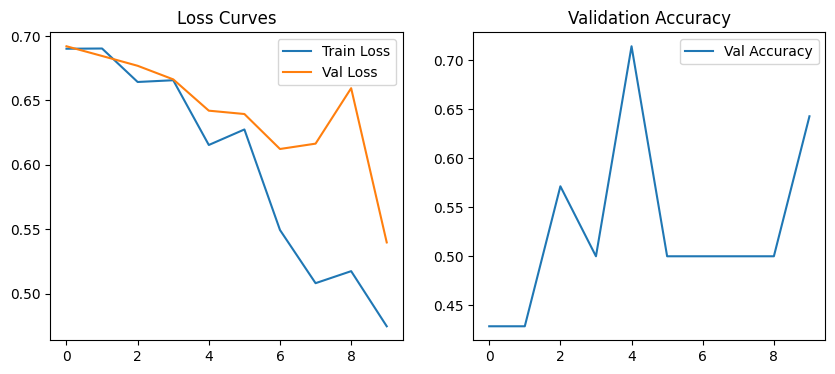

✅ Model saved as /content/healthnet_infrared.pth


In [6]:
import os, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

manifest_path = "/content/processed_ir_manifest.csv"
data = pd.read_csv(manifest_path)
print(f"✅ Loaded {len(data)} preprocessed images")

data['label'] = data['mask_status'].map({'mask': 0, 'no_mask': 1})

train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
print(f"Training: {len(train_df)} | Validation: {len(val_df)}")

class InfraredDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['processed_path']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(int(row['label']), dtype=torch.long)
        return img, label

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_ds = InfraredDataset(train_df, transform=train_tfms)
val_ds   = InfraredDataset(val_df, transform=val_tfms)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=16, shuffle=False)

class HealthNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HealthNet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_dl.dataset)
    train_loss_hist.append(epoch_loss)

    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dl.dataset)
    val_acc = correct / total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.2f}%")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.legend(); plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(val_acc_hist, label="Val Accuracy")
plt.legend(); plt.title("Validation Accuracy")
plt.show()

torch.save(model.state_dict(), "/content/healthnet_infrared.pth")
print("✅ Model saved as /content/healthnet_infrared.pth")

In [7]:
from torchvision import models

densenet = models.densenet121(weights='IMAGENET1K_V1')
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
densenet = densenet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet.parameters(), lr=1e-4)

EPOCHS = 10
best_acc = 0

for epoch in range(EPOCHS):
    densenet.train()
    train_loss = 0
    for imgs, labels in tqdm(train_dl, desc=f"DenseNet Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = densenet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    densenet.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = densenet(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch+1}: Val Acc = {val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(densenet.state_dict(), "/content/densenet_infrared.pth")
        print("✅ Best model saved!")

print(f"✅ Training complete. Best Val Accuracy: {best_acc*100:.2f}%")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 34.6MB/s]
DenseNet Epoch 1/10: 100%|██████████| 4/4 [00:45<00:00, 11.41s/it]


Epoch 1: Val Acc = 57.14%
✅ Best model saved!


DenseNet Epoch 2/10: 100%|██████████| 4/4 [00:40<00:00, 10.04s/it]


Epoch 2: Val Acc = 71.43%
✅ Best model saved!


DenseNet Epoch 3/10: 100%|██████████| 4/4 [00:34<00:00,  8.58s/it]


Epoch 3: Val Acc = 71.43%


DenseNet Epoch 4/10: 100%|██████████| 4/4 [00:35<00:00,  8.85s/it]


Epoch 4: Val Acc = 71.43%


DenseNet Epoch 5/10: 100%|██████████| 4/4 [00:34<00:00,  8.54s/it]


Epoch 5: Val Acc = 85.71%
✅ Best model saved!


DenseNet Epoch 6/10: 100%|██████████| 4/4 [00:32<00:00,  8.20s/it]


Epoch 6: Val Acc = 85.71%


DenseNet Epoch 7/10: 100%|██████████| 4/4 [00:33<00:00,  8.49s/it]


Epoch 7: Val Acc = 85.71%


DenseNet Epoch 8/10: 100%|██████████| 4/4 [00:32<00:00,  8.12s/it]


Epoch 8: Val Acc = 85.71%


DenseNet Epoch 9/10: 100%|██████████| 4/4 [00:34<00:00,  8.56s/it]


Epoch 9: Val Acc = 78.57%


DenseNet Epoch 10/10: 100%|██████████| 4/4 [00:32<00:00,  8.22s/it]


Epoch 10: Val Acc = 78.57%
✅ Training complete. Best Val Accuracy: 85.71%


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


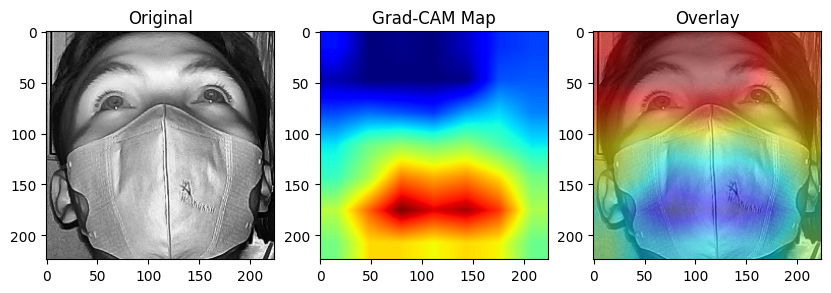

In [8]:
import numpy as np
import cv2
import torch
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx):
        output = self.model(input_tensor)
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

model_path = "/content/densenet_infrared.pth"
densenet.load_state_dict(torch.load(model_path, map_location=device))
densenet.eval()

target_layer = densenet.features[-1]

gradcam = GradCAM(densenet, target_layer)

sample_path = val_df.iloc[0].processed_path
img = Image.open(sample_path).convert('RGB')
transform = val_tfms
input_tensor = transform(img).unsqueeze(0).to(device)

output = densenet(input_tensor)
pred_class = output.argmax(dim=1).item()
cam = gradcam.generate(input_tensor, pred_class)

img_np = np.array(img.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("Grad-CAM Map")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay")
plt.show()

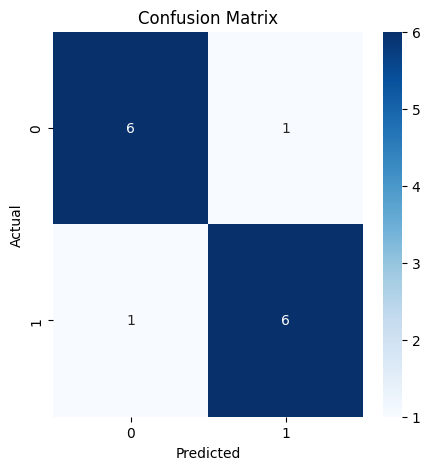

              precision    recall  f1-score   support

        mask       0.86      0.86      0.86         7
     no_mask       0.86      0.86      0.86         7

    accuracy                           0.86        14
   macro avg       0.86      0.86      0.86        14
weighted avg       0.86      0.86      0.86        14



In [9]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds, all_labels = [], []

densenet.eval()
with torch.no_grad():
    for imgs, labels in val_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = densenet(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(all_labels, all_preds, target_names=['mask','no_mask']))